In [39]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from PIL import Image
import cv2

In [19]:
path_to_data = r"../input/waste-dataset/data"

train_ds = tf.keras.utils.image_dataset_from_directory(
    path_to_data,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(256, 256),
    batch_size=32,
    shuffle=True 
)

valid_ds = tf.keras.utils.image_dataset_from_directory(
    path_to_data,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(256, 256),
    batch_size=32,
    shuffle=True 
)

Found 248 files belonging to 4 classes.
Using 199 files for training.
Found 248 files belonging to 4 classes.
Using 49 files for validation.


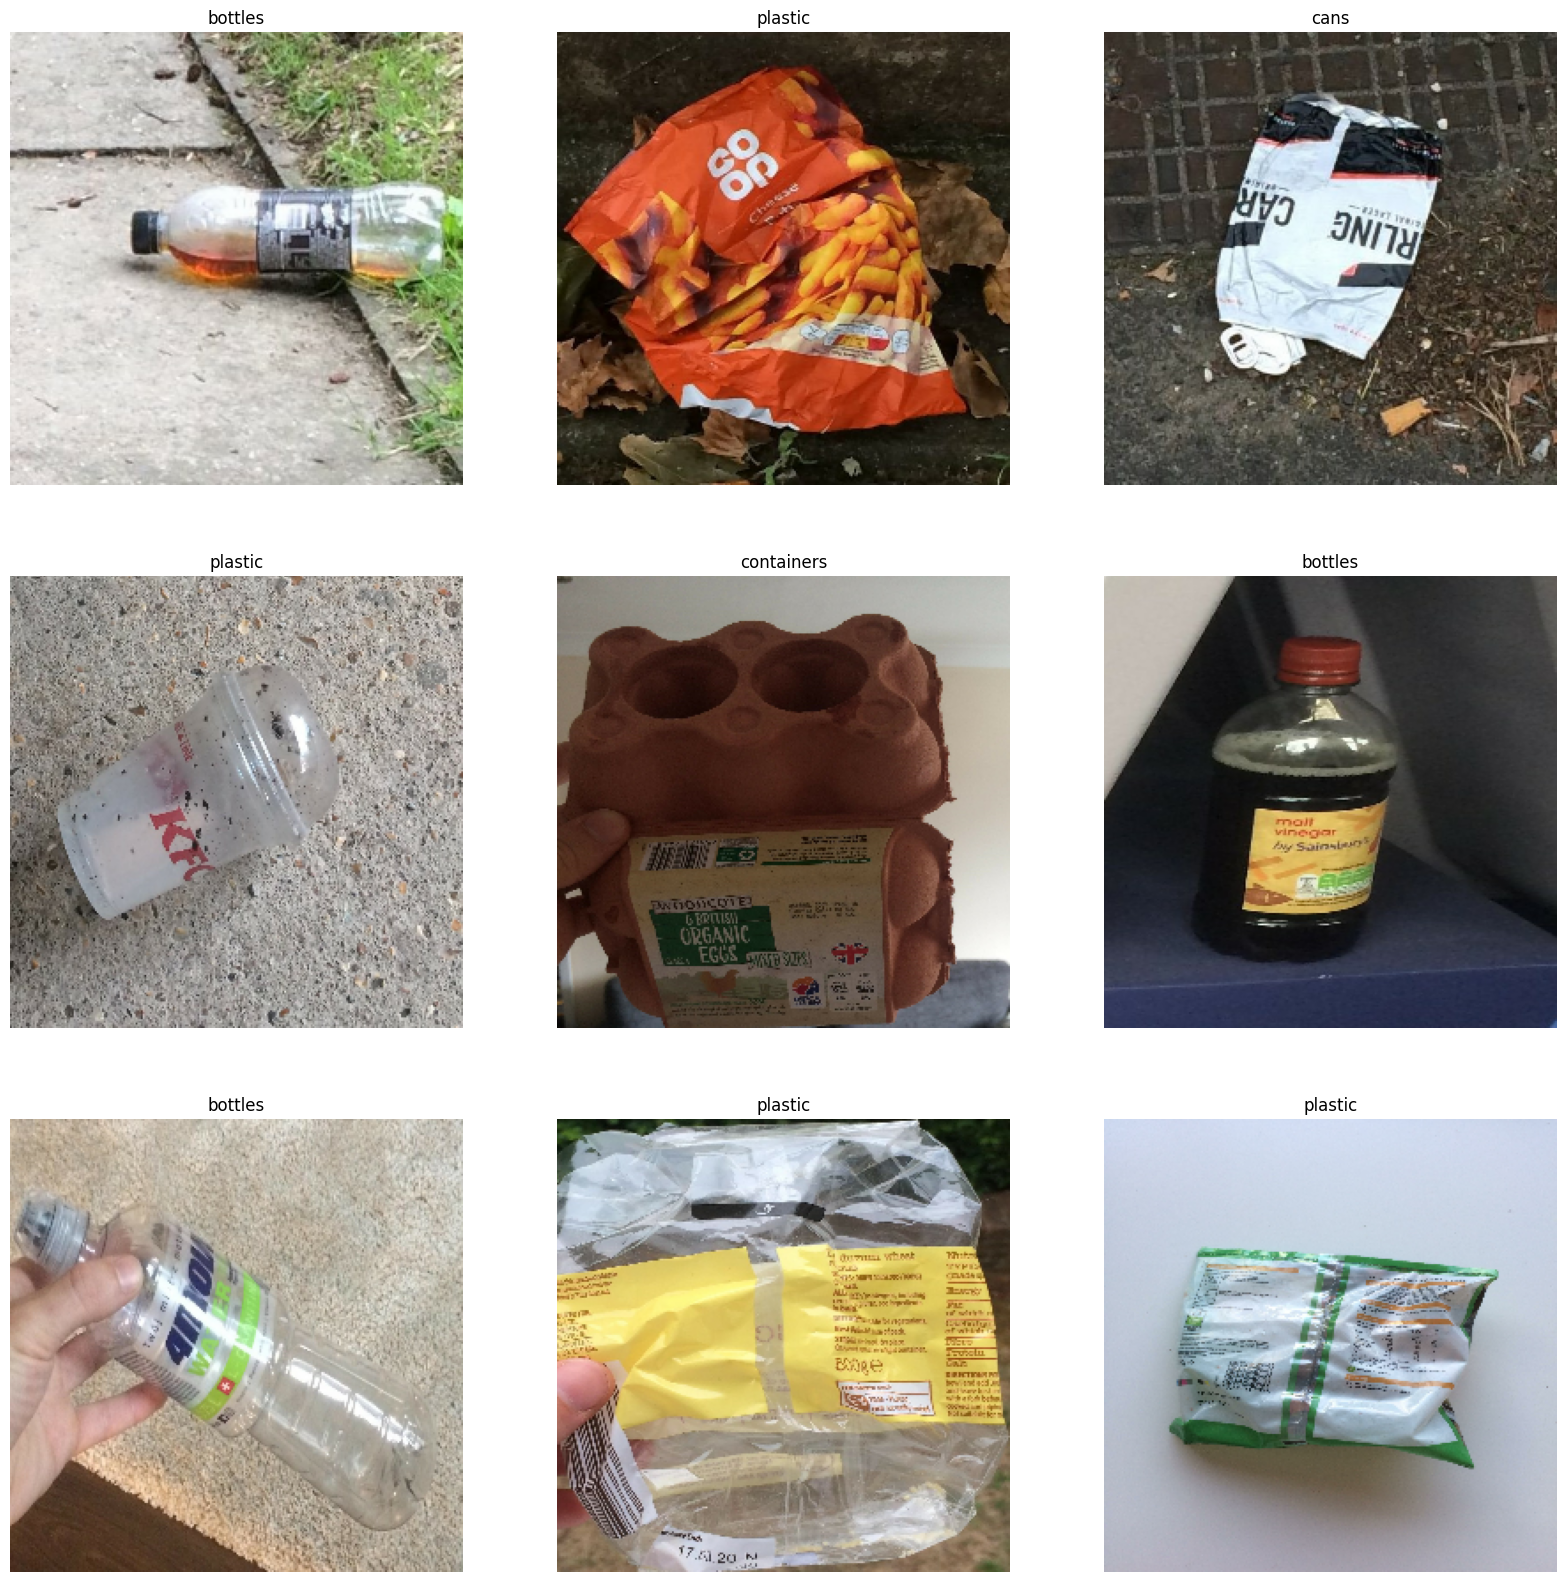

In [36]:
class_names = train_ds.class_names

plt.figure(figsize=(20, 20))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [40]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [72]:
class EqualiseHistorgram(tf.keras.layers.Layer):
    def __init__(self):
        super(EqualiseHistorgram, self).__init__()

    def call(self, inputs):
        images = inputs * 255.0
        
        def equalize(image):
            equalised_image = cv2.equaliseHist(image)
            return equalised_image
            
        
        outputs = tf.map_fn(equalize, images, dtype=tf.float32)
        return outputs

equaliser = tf.keras.Sequential([ EqualiseHistorgram ])

AttributeError: module 'keras._tf_keras.keras.layers' has no attribute 'EqualiseHistorgram'

In [ ]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)